In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_parquet("train.parquet", engine = "pyarrow")
test = pd.read_parquet("test.parquet", engine = "pyarrow")

In [3]:
X_train, y_train = train["clean_text"].values, train["HATEFUL"].values
X_test, y_test = test["clean_text"].values, test["HATEFUL"].values

In [4]:
param_grid = {'nb__alpha': [0.01, 0.1, 0.5, 1, 5, 10]}

In [5]:
pipeline = Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("nb", ComplementNB())
])

In [6]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

In [7]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', ComplementNB())]),
             n_jobs=-1, param_grid={'nb__alpha': [0.01, 0.1, 0.5, 1, 5, 10]},
             scoring='roc_auc')

In [8]:
grid_search.best_params_

{'nb__alpha': 0.1}

In [12]:
y_pred = grid_search.best_estimator_.predict(X_test)
y_pred_train = grid_search.best_estimator_.predict(X_train)

In [13]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     28462
           1       0.66      0.95      0.78      5178

    accuracy                           0.92     33640
   macro avg       0.83      0.93      0.87     33640
weighted avg       0.94      0.92      0.92     33640



In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      8961
           1       0.41      0.60      0.48      1682

    accuracy                           0.80     10643
   macro avg       0.66      0.72      0.68     10643
weighted avg       0.84      0.80      0.81     10643



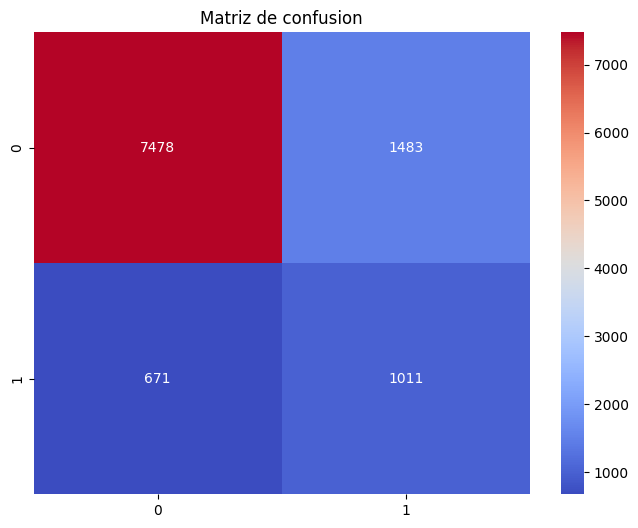

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.title("Matriz de confusion")
sns.heatmap(cm, annot=True, fmt = "d", cmap="coolwarm")
plt.show()

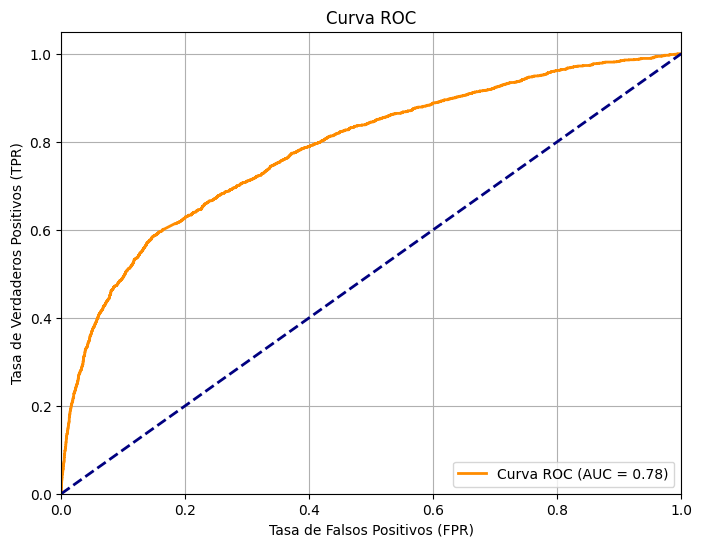

In [37]:
y_scores = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [14]:
y_scores_train = grid_search.best_estimator_.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_scores_train)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_train

0.9837221314296561